<a href="https://colab.research.google.com/github/khalidpark/machinelearning_whitepaper/blob/main/Machine_learning_whitepaper_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
df = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv')


In [2]:
## 컬럼명을 살펴봅시다.
df.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [3]:
## 데이터의 75% 갯수
len(df)*0.75


1095.0

In [4]:
## train/test 데이터를 sample 메소드를 사용해 나누겠습니다.
train = df.sample(frac=0.75,random_state=1)
test = df.drop(train.index)


In [5]:
## train, test 길이 비교
len(train), len(test)


(1095, 365)



---



In [6]:
# SalePrice 평균
train['SalePrice'].mean()


180327.24200913243

In [7]:
# label 정의
target = 'SalePrice'
y_train = train[target]
y_test = test[target]


In [8]:
# SalePrice 평균값으로 예측(기준모델)
predict = y_train.mean()


In [9]:
predict

180327.24200913243

In [10]:
# 기준모델로 훈련 에러(MAE) 계산
from sklearn.metrics import mean_absolute_error
y_pred = [predict] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)

print(f'훈련 에러: {mae:.2f}')


훈련 에러: 57775.57


In [11]:
# 테스트 에러(MAE)
y_pred = [predict] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')


테스트 에러: 55862.90



scikit-learn을 사용해서 단순선형회귀모델을 만들자 우선

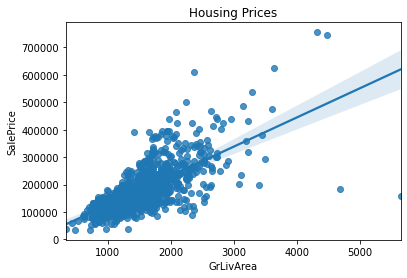

In [12]:
import seaborn as sns
sns.regplot(x=train['GrLivArea'], y=train['SalePrice']).set_title('Housing Prices');


In [13]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

features = ['GrLivArea']
X_train = train[features]
X_test = test[features]

# 모델 fit
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')


훈련 에러: 38327.78


In [14]:
# 테스트 데이터에 적용
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')


테스트 에러: 35476.63


기준모델과 비교해 보면 에러가 줄어든 것을 확인할 수 있습니다.



---



scikit-learn을 사용해서 다중선형회귀 모델을 만들어 봅시다.



In [16]:
# 다중모델 학습을 위한 특성
features = ['GrLivArea', 
            'OverallQual']
X_train = train[features]
X_test = test[features]


In [17]:
# 모델 fit
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'훈련 에러: {mae:.2f}')


훈련 에러: 29129.58


In [18]:
# 테스트 데이터에 적용해 봅시다 
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트 에러: {mae:.2f}')


테스트 에러: 27598.31


하나의 특성을 사용한 단순선형회귀모델보다 테스트 오류가 더 줄어든 것을 확인할 수 있습니다



---



단순선형회귀에서는 모델이 직선의 방정식으로 표현이 되었다면, 이번에는 특성이 두 개이므로 평면의 방정식으로 표현이 됩니다.

Plotly를 사용하여 3D 평면을 표현해 보겠습니다.

In [19]:
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
import itertools

def surface_3d(df, f1, f2, target, length=20, **kwargs):
    """
    2특성 1타겟 선형모델평면을 시각화 합니다.
    
    df : 데이터프레임
    f1 : 특성 1 열 이름
    f2 : 특성 2 열 이름
    target : 타겟 열 이름
    length : 각 특성의 관측치 갯수
    
    """
    
    # scatter plot(https://plotly.com/python-api-reference/generated/plotly.express.scatter_3d)
    plot = px.scatter_3d(df, x=f1, y=f2, z=target, opacity=0.5, **kwargs)
    
    # 다중선형회귀방정식 학습
    model = LinearRegression()
    model.fit(df[[f1, f2]], df[target])    

    # 좌표축 설정
    x_axis = np.linspace(df[f1].min(), df[f1].max(), length)
    y_axis = np.linspace(df[f2].min(), df[f2].max(), length)
    coords = list(itertools.product(x_axis, y_axis))
    
    # 예측
    pred = model.predict(coords)
    z_axis = pred.reshape(length, length).T
    
    # plot 예측평면
    plot.add_trace(go.Surface(x=x_axis, y=y_axis, z=z_axis, colorscale='Viridis'))
    
    return plot


In [20]:
surface_3d(
    train,
    f1='GrLivArea', 
    f2='OverallQual', 
    target='SalePrice',  
    title='House Prices'
)




---



회귀계수를 해석

In [21]:
## 절편(intercept)과 계수들(coefficients)
model.intercept_, model.coef_


(-102743.02342270731, array([   54.40145532, 33059.44199506]))

In [22]:
## 회귀식을 만들어 봅시다.
b0 = model.intercept_
b1, b2 = model.coef_

print(f'y = {b0:.0f} + {b1:.0f}x\u2081 + {b2:.0f}x\u2082')


y = -102743 + 54x₁ + 33059x₂


$\beta_1$과 $\beta_2$ 모두 양수입니다. 이것은 $x_1$, $x_2$이 증가할 때마다 $y$ 도 증가한다는 뜻입니다. 만약 음수인 경우에는 $y$ 가 감소한다는 뜻이겠지요.

